In [78]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

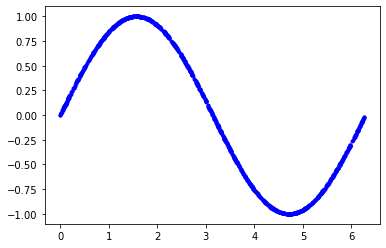

In [79]:
SAMPLES = 1000

seed = 1 # "random"
np.random.seed(seed)
tf.random.set_seed(seed)

x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)
np.random.shuffle(x_values)
y_values = np.sin(x_values).astype(np.float32)

plt.plot(x_values, y_values, 'b.')

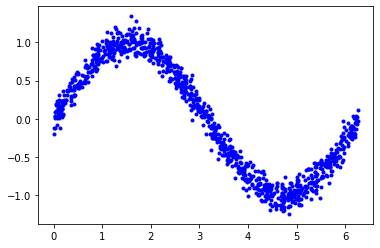

In [80]:
y_values += 0.1 * np.random.randn(*y_values.shape)

plt.plot(x_values, y_values, 'b.')

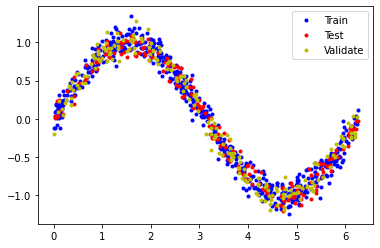

In [81]:
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()

In [82]:
model = tf.keras.Sequential([
  keras.layers.Dense(16, activation='relu', input_shape=(1,)),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss="mse", metrics=["mae"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 [==============================] - 1s 18ms/step - loss: 0.6834 - mae: 0.7333 - val_loss: 0.5412 - val_mae: 0.6609
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4666 - mae: 0.6007 - val_loss: 0.4645 - val_mae: 0.5874
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4398 - mae: 0.5616 - val_loss: 0.4478 - val_mae: 0.5724
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4226 - mae: 0.5469 - val_loss: 0.4266 - val_mae: 0.5610
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4011 - mae: 0.5373 - val_loss: 0.4085 - val_mae: 0.5519
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3841 - mae: 0.5304 - val_loss: 0.3925 - val_mae: 0.5430
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3680 - mae: 0.5197 - val_loss: 0.3759 - val_mae: 0.5318
Epoch 8/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3520 - 

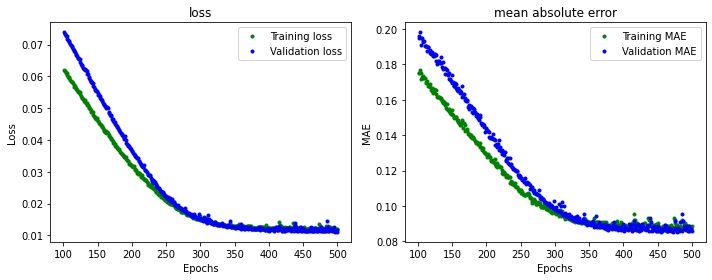

In [84]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0832


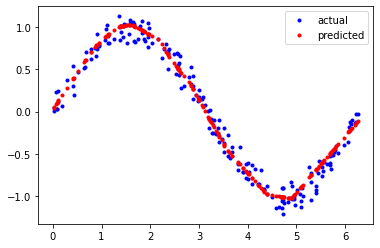

In [85]:
test_loss, test_mae = model.evaluate(x_test, y_test)
y_test_pred = model.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'b.', label='actual')
plt.plot(x_test, y_test_pred, 'r.', label='predicted')
plt.legend()
plt.show()

In [86]:
import json

MODEL_TF = 'sin_model'
MODEL_TFLITE = MODEL_TF + '.tflite'
MODEL_TFLITE_QUANTIZATION_PARAMS = MODEL_TF + '_quantization_params.json'

model.save(MODEL_TF)
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

interpreter = tf.lite.Interpreter(model_content=model_tflite)
quantization_input_params = interpreter.get_input_details()[0]['quantization'] 
quantization_output_params = interpreter.get_output_details()[0]['quantization']

with open(MODEL_TFLITE_QUANTIZATION_PARAMS, 'w') as f:
  f.write(json.dumps({
      'input': {
          'scale': quantization_input_params[0],
          'zero_point': quantization_input_params[1]
      },
      'output': {
          'scale': quantization_output_params[0],
          'zero_point': quantization_output_params[1]
      }
  }))

pd.DataFrame.from_records(
    [["Input", quantization_input_params[0], quantization_input_params[1]],
     ["Output", quantization_output_params[0], quantization_output_params[1]]],
     columns = ["Input/Output", "Scale", "Zero Point"], index="Input/Output")

INFO:tensorflow:Assets written to: sin_model/assets


,Scale,Zero Point
Input/Output,,
Input,0.024574,-128
Output,0.008045,-1


In [87]:
MODEL_TFLITE_MICRO = MODEL_TF + '.cc'

!apt-get update && apt-get -qq install xxd
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [88]:
!cat {MODEL_TFLITE_MICRO}

unsigned char sin_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0xa4, 0x00, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00,
  0x28, 0x03, 0x00, 0x00, 0x38, 0x03, 0x00, 0x00, 0x34, 0x09, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x24, 0x00, 0x00, 0x00, 0x44, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xb8, 0xff, 0xff, 0xff,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
 

In [89]:
!rm -rf model 
!mkdir model
from shutil import make_archive, copy, move

move(MODEL_TF, 'model')
move(MODEL_TFLITE, 'model')
move(MODEL_TFLITE_QUANTIZATION_PARAMS, 'model')
move(MODEL_TFLITE_MICRO, 'model')

make_archive('model', 'zip', base_dir='model')

'model.zip'